In [ ]:
!apt-get update && apt-get install -y graphviz
!pip install expecttest pydot

In [1]:
import torch
import torch.fx
import torch.nn as nn
print(torch.__version__)

2.0.1


In [2]:
import tensorrt
print(tensorrt.__version__)

8.4.2.4


In [3]:
import torch_tensorrt
print(torch_tensorrt.__version__)

1.4.0


In [4]:
from torch_tensorrt.fx.tracer.acc_tracer import acc_normalizer, acc_ops, acc_shape_prop, acc_utils  # noqa: F401
from torch.fx.experimental.normalize import NormalizeArgs

import torch_tensorrt
from torch_tensorrt.fx.utils import LowerPrecision
import torch_tensorrt.fx.tracer.acc_tracer.acc_tracer as acc_tracer
from torch_tensorrt.fx import InputTensorSpec, TRTInterpreter, TRTModule
from torch_tensorrt.fx.tools.trt_splitter import TRTSplitter, TRTSplitterSetting

In [5]:
from torch.fx.node import Argument, Target
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
from torch_tensorrt.fx.converters.converter_utils import SourceIR
from torch_tensorrt.fx.converter_registry import tensorrt_converter
from torch_tensorrt.fx.tracer.acc_tracer.acc_op_properties import AccOpProperty, register_acc_op_properties
from torch_tensorrt.fx.tracer.acc_tracer.acc_normalizer import (
    register_acc_op,
    register_acc_op_mapping,
    register_custom_acc_mapper_fn,
)
from torch_tensorrt.fx.types import (
    TRTNetwork,
    TRTTensor,
)
from torch_tensorrt.fx.converters.impl import activation

In [ ]:
import tensorrt as trt
TRT_LOGGER = trt.Logger(trt.Logger.ERROR)
trt.init_libnvinfer_plugins(TRT_LOGGER, "")
print(f"Register libnvinfer plugins")
registry = trt.get_plugin_registry()
print(f"Registry: {registry}")
for plugin in registry.plugin_creator_list:
    print(plugin.name)

In [ ]:
from torch_tensorrt.fx.converter_registry import CONVERTERS
from torch_tensorrt.fx.tracer.acc_tracer.acc_normalizer import _acc_ops, _normalization_dict
from torch_tensorrt.fx.tracer.acc_tracer import acc_ops

print(">>" * 40)
print("Converters")
print(">>" * 40)
for op in CONVERTERS:
    print(op)
    
print(">>" * 40)
print("acc_ops")
print(">>" * 40)
for op in _acc_ops:
    print(op)
    
print(">>" * 40)
print("_normalization_dict")
print(">>" * 40)
for op in _normalization_dict:
    print(op)

In [ ]:
for op in list(CONVERTERS.keys()):
    if op == acc_ops.gelu:
        CONVERTERS.pop(op)
        print(f"removed converter {op}")

for op in list(_acc_ops):
    if op.__name__ == "gelu":
        _acc_ops.remove(op)
        print(f"removed acc_op: {op}")
        
for (op, target) in list(_normalization_dict.keys()):
    if "gelu" in str(target) or "GELU" in str(target):
        _normalization_dict.pop((op, target))
        print(f"removed normalization_dict op: {op}")

In [ ]:
import ctypes
from pathlib import Path


def load_torchtrt_plugins():
    # ctypes.CDLL(osp.join(dir_path, 'libamirstan_plugin.so'))
    # suppose plugins lib installed into HOME
    lib_path = Path(torch_tensorrt.__file__).parent / "lib"
    print(f"Using torch_tensorrt: {torch_tensorrt.__version__}, lib_path={lib_path}")
    # "libtorchtrt.so", "libtorchtrt_runtime.so", 
    for lib in ["libtorchtrt_plugins.so"]:
        path = lib_path / lib
        if not path.exists():
            print(f"Failed to load lib: {path}")
        ctypes.CDLL(str(path))
        print(f"Loaded {path}")

load_torchtrt_plugins()

In [ ]:
for item in registry.plugin_creator_list:
    print(item.name, item.plugin_version, item.plugin_namespace)

In [ ]:
plugin.plugin_namespace

In [ ]:
plugin.plugin_version

In [ ]:
import tensorrt as trt

trt.ITensor?

In [ ]:
@register_acc_op_properties(AccOpProperty.pointwise, AccOpProperty.unary)
@register_acc_op_mapping(op_and_target=("call_function", torch.nn.functional.gelu))
@register_acc_op_mapping(op_and_target=("call_method", "gelu"))
@register_custom_acc_mapper_fn(
    op_and_target=("call_module", torch.nn.GELU),
    arg_replacement_tuples=[
        ("input", "input"),
    ],
)
@register_acc_op
def gelu(*, input):
    return nn.functional.relu(input=input, inplace=False)


# @tensorrt_converter(torch.nn.functional.gelu)
# @tensorrt_converter(torch.nn.modules.activation.GELU)
# def _gelu(network, submod, args, kwargs, layer_name):
#     # args/kwargs should have already been normalized to kwargs
#     assert len(args) == 0

#     return activation.relu(
#         network=network,
#         target="torch.nn.functional.relu",
#         source_ir=SourceIR.NN,
#         name=layer_name,
#         input_val=kwargs["input"],
#     )


# @register_acc_op_mapping(
#     op_and_target=("call_function", torch.nn.modules.GroupNorm),
#     arg_replacement_tuples=[
#         ("input", "input"),
#         ("num_groups", "num_groups"),
#         ("weight", "weight"),
#         ("bias", "bias"),
#         ("eps", "eps"),
#     ],
# )
# @register_acc_op
# def group_norm(*, input, num_groups, weight=None, bias=None, eps=1e-05):
#     return GroupNormalizationPlugin.apply(input, self.weight, self.bias, self.num_groups, self.eps)
#     return torch.nn.functional.group_norm(
#         input, num_groups, weight=weight, bias=bias, eps=eps
#     )

In [ ]:
# auto creator = getPluginRegistry()->getPluginCreator("Interpolate", "1", "torch_tensorrt");
# auto interpolate_plugin = creator->createPlugin(name, &fc);

# auto resize_layer = ctx->net->addPluginV2(reinterpret_cast<nvinfer1::ITensor* const*>(&in), 1, *interpolate_plugin);
# TORCHTRT_CHECK(resize_layer, "Unable to create interpolation plugin from node" << *n);

# resize_layer->setName(util::node_info(n).c_str());

# auto layer_output = ctx->AssociateValueAndTensor(n->outputs()[0], resize_layer->getOutput(0));

creator = trt.get_plugin_registry().get_plugin_creator("GroupNormalizationPlugin", "1", "torch_tensorrt")

In [ ]:
from torch_tensorrt.fx.converter_registry import tensorrt_converter


def gelu_fn(x):
    """
    https://github.com/geohot/tinygrad/blob/18892242b006785d4e92abae7c792e7874c17df9/tinygrad/tensor.py#L522
    """
    return 0.5 * x * (1 + (x * 0.7978845608 * (1 + 0.044715 * x * x)).tanh())


@tensorrt_converter(torch.nn.functional.gelu)
@tensorrt_converter(torch.nn.modules.activation.GELU)
def relu(network, submod, args, kwargs, layer_name):
    # args/kwargs should have already been normalized to kwargs
    assert len(args) == 0

    return activation.relu(
        network=network,
        target="torch.nn.functional.relu",
        source_ir=SourceIR.NN,
        name=layer_name,
        input_val=kwargs["input"],
    )



In [ ]:
import torch
import torch.nn as nn
import torch_tensorrt as torchtrt


# Create a sample network with a conv and gelu node.
# Gelu layer in Torch-TensorRT is converted to CustomGeluPluginDynamic from TensorRT plugin registry.
class ConvGelu(torch.nn.Module):
    def __init__(self):
        super(ConvGelu, self).__init__()
        self.conv = nn.Conv2d(3, 32, 3, 1)
        # self.gelu = nn.GELU()

    def forward(self, x):
        x = self.conv(x)
        # x = self.gelu(x)
        x = torch.nn.functional.gelu(x)
        # x = gelu_fn(x)
        return x
    
model = ConvGelu().eval().cuda()

In [ ]:
torchtrt.Input?

In [ ]:
from torch.fx import symbolic_trace, replace_pattern

# Replace `pattern` with `replacement` in `traced`
traced = symbolic_trace(model)
print(traced)

In [ ]:
# Define the pattern. The FX Subgraph Rewriter will match all
# non-overlapping instances of the pattern in the larger graph.
# Note that Pattern-matching is done based on data dependencies,
# not Node names. Even though we're operating on Nodes named `a1` and
# `a2` instead of `w1` and `w2`, the pattern is still a valid match
# for the two instances of `torch.cat([w1, w2]).sum()` above. Only
# operations that contribute to the single output value of the pattern
# are considered
def pattern(x):
    return torch.nn.functional.gelu(x)

# Define the replacement (same rules as the pattern)
def replacement(x):
    return gelu_fn(x)

replace_pattern(traced, pattern, replacement)
print(traced)

In [ ]:
shape = [1, 3, 5, 5]
compile_settings = {
    "inputs": [torchtrt.Input(shape, dtype=torch.float32)],
    "enabled_precisions": {torch.float32},
}
with torch.inference_mode():
    scripted_model = torch.jit.script(traced)

In [ ]:
scripted_model.graph

In [ ]:
with torch.inference_mode():
    trt_traced = acc_tracer.trace(
        traced, [torch.rand(*shape, dtype=torch.float32, device="cuda")], 
    )
trt_traced.graph.print_tabular()

In [ ]:
trt_ts_module = torchtrt.compile(scripted_model, **compile_settings)
torch.jit.save(trt_ts_module, "conv_gelu.jit")
print("Generated Torchscript-TRT GELU model.")

In [ ]:
trt_ts_module.graph

In [ ]:
x = torch.rand(*shape, dtype=torch.float32, device="cuda")
with torch.inference_mode():
    trt_traced = acc_tracer.trace(model, [x])

    splitter = TRTSplitter(trt_traced, [x])
    splitter.node_support_preview(dump_graph=True)

In [ ]:
from IPython.display import Image
import pydot

graphs = pydot.graph_from_dot_file("node_support.dot")
Image(graphs[0].create_png())

In [ ]:
trt_ts_gelu_model = torch.load("conv_gelu.jit")

In [ ]:
%%timeit -n 10
trt_ts_gelu_model(x)

In [ ]:
trt.float32

In [ ]:
import torch
import torch.nn as nn
import torch_tensorrt as torchtrt

# create a simple norm layer.
# This norm layer uses NormalizePlugin from Torch-TensorRT

class Norm(torch.nn.Module):
    def __init__(self, C: int):
        super(Norm, self).__init__()
        self.gn = nn.GroupNorm(C // 2, C)

    def forward(self, x):
        return self.gn(x)
#         num_groups = 2
#         return torch.nn.functional.group_norm(
#             x, num_groups, eps=1e-05
#         )

In [ ]:
C = 6
norm_model = Norm(C).eval().cuda()
# with torch.inference_mode():
#     norm_ts_module = torch.jit.script(norm_model)

In [ ]:
norm_ts_module.graph

In [ ]:
shape = [1, C, 64, 64]
x = torch.rand(*shape, dtype=torch.float32, device="cuda")
with torch.inference_mode():
    trt_traced = acc_tracer.trace(norm_model, [x])
print(trt_traced)

In [ ]:
# compile_settings = {
#     "inputs": [torchtrt.Input(shape, dtype=torch.float32)],
#     "enabled_precisions": {torch.float32},
# }

# norm_trt_ts = torchtrt.compile(norm_ts_module, **compile_settings)
# torch.jit.save(norm_trt_ts, "norm_trt_ts.pt")
# print("Generated Torchscript-TRT GroupNorm model.")

In [ ]:
# print(norm_trt_ts.graph)

In [ ]:
import torch
from typing import Sequence
from torch_tensorrt.dynamo.backend._settings import CompilationSettings
from torch_tensorrt.dynamo.backend.lowering._partition import (
    partition,
    get_submod_inputs,
)
from torch_tensorrt.dynamo.backend.lowering._partition import logger as plogger
from torch_tensorrt.dynamo.backend.conversion import convert_module


# def _compile_module(
#     gm: torch.fx.GraphModule,
#     sample_inputs: Sequence[torch.Tensor],
#     settings: CompilationSettings = CompilationSettings(),
# ) -> torch.fx.GraphModule:
#     """Compile a traced FX module

#     Includes: Partitioning + Conversion Phases

#     Args:
#         module: FX GraphModule to convert
#         inputs: Inputs to the module
#         settings: Compilation settings
#     Returns:
#         Compiled FX GraphModule
#     """
#     # Partition module into components that can be TRT-accelerated
#     level = plogger.level
#     plogger.setLevel(logging.DEBUG)
#     partitioned_module = partition(
#         gm,
#         verbose=settings.debug,
#         min_block_size=settings.min_block_size,
#         torch_executed_ops=settings.torch_executed_ops,
#     )
#     plogger.setLevel(level)

#     # Iterate over all components that can be accelerated
#     # Generate the corresponding TRT Module for those
#     for name, _ in partitioned_module.named_children():
#         if "_run_on_acc" not in name:
#             continue
#         submodule = getattr(partitioned_module, name)

#         # Get submodule inputs
#         submodule_inputs = get_submod_inputs(
#             partitioned_module, submodule, sample_inputs
#         )

#         # Create TRT Module from submodule
#         trt_mod = convert_module(
#             submodule,
#             submodule_inputs,
#             settings=settings,
#         )

#         # Replace FX Module with TRT Module
#         setattr(partitioned_module, name, trt_mod)

#     return partitioned_module

In [ ]:
# from torch_tensorrt.dynamo.backend.lowering._partition import (
#     partition,
#     get_submod_inputs,
# )
# from torch_tensorrt.dynamo.backend.lowering._partition import logger as plogger

# # with torch.inference_mode():
# #     splitter = TRTSplitter(trt_traced, [x])
# #     # splitter.node_support_preview(dump_graph=False)
# import logging
# logger = logging.getLogger(__name__)


# level = plogger.level
# plogger.setLevel(logging.DEBUG)
# partitioned_module = partition(
#     trt_traced,
#     verbose=True,
#     min_block_size=0,
#     torch_executed_ops=[],
# )
# plogger.setLevel(level)


# # Since the model is splitted into three segments. We need to lower each TRT eligible segment.
# # If we know the model can be fully lowered, we can skip the splitter part.
# inputs = [x]
# for name, _ in partitioned_module.named_children():
#     print(f"Splitting {name}")
#     if "_run_on_acc" in name:
#         submodule = getattr(partitioned_module, name)

#         # Get submodule inputs for fx2trt
#         submodule_inputs = get_submod_inputs(partitioned_module, submodule, inputs)

#         # Create TRT Module from submodule
#         trt_mod = convert_module(
#             submodule,
#             submodule_inputs,
#             settings=settings,
#         )
        
#         setattr(partitioned_module, name, trt_mod)

In [ ]:
# del model
# del pipe
# del traced_unet

with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torch_tensorrt as torchtrt
from torch_tensorrt.fx.tools.trt_splitter import TRTSplitter, TRTSplitterSetting

import nos.compilers.trt as nostrt
import nos.compilers.trt.ops
from nos.compilers.trt.ops import group_norm as gn
import torch_tensorrt.fx.tracer.acc_tracer.acc_tracer as acc_tracer
from torch_tensorrt.fx.utils import LowerPrecision
from torch_tensorrt.dynamo.backend._defaults import (
    PRECISION,
    DEBUG,
    MAX_WORKSPACE_SIZE,
    MIN_BLOCK_SIZE,
    PASS_THROUGH_BUILD_FAILURES,
)


class Norm(torch.nn.Module):
    def __init__(self, C: int):
        super(Norm, self).__init__()
        self.gn = nn.GroupNorm(C // 2, C)

    def forward(self, x):
        return self.gn(x)


C = 6
dtype = torch.float16
shape = [1, C, 64, 64]
model = Norm(C).eval().cuda()
if dtype == torch.float16:
    model = model.half()

x = torch.randn(shape, dtype=dtype, device="cuda")
inputs = [x]

traced_model = torch.jit.trace(model, inputs)
traced_model

In [ ]:
from torch import fx
from transformers.utils.fx import HFTracer, get_concrete_args
from transformers import CLIPModel

import torch_tensorrt.fx.converter_registry as registry
registry.CONVERTERS.pop(acc_ops.expand)


dtype = torch.float32
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda().eval()
model = model.vision_model
if dtype == torch.float32: # CLIP is already in half-mode
    model = model.float()
    
shape = [1, 3, 224, 224]
x = torch.randn(shape, dtype=dtype, device='cuda')
args = {
    "pixel_values": x
}
concrete_args = {
    "output_attentions": None,
    "output_hidden_states": None,
    "return_dict": True
}
inputs = list(args.values())

tracer = HFTracer()
traced_graph = tracer.trace(model, concrete_args=concrete_args, dummy_inputs=args)
traced_model = torch.fx.GraphModule(model, traced_graph)
# print(traced_model.graph)

In [39]:
from diffusers import DiffusionPipeline
from diffusers import DDIMScheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from diffusers.models.unet_2d_condition import UNet2DConditionOutput

dtype = torch.float32
# Use the DDIMScheduler scheduler here instead
scheduler = DDIMScheduler.from_pretrained("stabilityai/stable-diffusion-2-1",
                                            subfolder="scheduler")
# pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1")
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=dtype, scheduler=scheduler)
pipe = pipe.to("cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [ ]:
from torch import fx
from transformers.utils.fx import HFTracer

model = pipe.vae

# https://github.com/huggingface/diffusers/blob/666743302ff5bd1e02c204b81a80e566648d60de/examples/community/stable_diffusion_tensorrt_txt2img.py#L493
H, W = 512, 512 
B = 1
x = torch.rand(B, 3, H // 8, W // 8, dtype=dtype, device="cuda")
args = {
    'sample': x,
}
concrete_args = {
    "sample_posterior": False,
    "return_dict": True,
    "generator": None,
}
inputs = list(args.values())

tracer = HFTracer()
with torch.inference_mode():
    traced_graph = tracer.trace(model, concrete_args=concrete_args, dummy_inputs=args)
    traced_model = torch.fx.GraphModule(model, traced_graph)
# print(traced_graph.print_tabular())

traced_model.config = model.config
# The model class must be stored as an attribute to allow model deserialization, which uses trace, and thus
# _generate_dummy_input, where the model class is needed.
traced_model.class_for_deserialization = model.__class__
traced_model.device = model.device

In [40]:
from torch import fx
from transformers.utils.fx import HFTracer

model = pipe.unet

# https://github.com/huggingface/diffusers/blob/666743302ff5bd1e02c204b81a80e566648d60de/examples/community/stable_diffusion_tensorrt_txt2img.py#L493
H, W = 512, 512
B = 1
D = 1024  # D = (v1-5: 768, v2-1: 1024)
unet_dim = 4
text_maxlen = 77

device = "cuda"
sample = torch.rand(2 * B, unet_dim, 96, 96, dtype=dtype, device=device)
timestep = torch.tensor([1, ], dtype=torch.int32, device=device)
encoder_hidden_states = torch.rand((2 * B, text_maxlen, D), dtype=dtype, device=device)  # 2B, 77, 1024

args = {
    'sample': sample,
    'timestep' : timestep,
    'encoder_hidden_states': encoder_hidden_states,
}
concrete_args = {
    'class_labels': None,
    'timestep_cond' : None,
    'attention_mask': None,
    'cross_attention_kwargs': None,
    'added_cond_kwargs': None,
    'down_block_additional_residuals': None,
    'mid_block_additional_residual': None,
    'encoder_attention_mask':None,
    'return_dict': True,
    'hidden_states': None,
    'cond_proj_dim' : 1,
    'condition': None,
    'use_ada_layer_norm': True,
    'input_ndim': 4,
}
inputs = list(args.values())

tracer = HFTracer()
# with torch.inference_mode():
traced_graph = tracer.trace(model, concrete_args={**args, **concrete_args})
traced_model = torch.fx.GraphModule(model, traced_graph)
# print(traced_graph.print_tabular())

traced_model.config = model.config
# The model class must be stored as an attribute to allow model deserialization, which uses trace, and thus
# _generate_dummy_input, where the model class is needed.
traced_model.class_for_deserialization = model.__class__
traced_model.device = model.device

In [ ]:
# model(*inputs)

In [41]:
import torch.nn as nn

class TracedModelWithNoInputs(nn.Module):
    def __init__(self, traced_model):
        super().__init__()
        self._model = traced_model
        self._input_idx2name = {}
        for key in dir(self._model):
            if key.startswith("_tensor_constant"):
                self._input_idx2name[len(self._input_idx2name)] = key
        print(f"Found inputs: {len(self._input_idx2name)}")

        self.config = None
        self.class_for_deserialization = None
        self.device = None
        
    def forward(self, sample, timestep, encoder_hidden_states, class_labels=None, cross_attention_kwargs=None, return_dict=True):
        args = (sample, timestep, encoder_hidden_states)
        idx = 0
        for arg in args:
            key = self._input_idx2name[idx]
            setattr(self._model, key, arg)
            print(f"setting {key}: {arg.shape}, old: {getattr(self._model, key).shape}")
            idx += 1
        # for _key, value in kwargs.items():
        #     print(f"kwarg: {_key}")
        #     if idx not in self._input_idx2name:
        #         break
        #     key = self._input_idx2name[idx]
        #     setattr(self._model, key, value)
        #     print(f"setting {key}: {value.shape}")
        #     idx += 1
        return UNet2DConditionOutput(self._model())
        
traced_unet = TracedModelWithNoInputs(traced_model)
traced_unet.config = pipe.unet.config
# The model class must be stored as an attribute to allow model deserialization, which uses trace, and thus
# _generate_dummy_input, where the model class is needed.
traced_unet.class_for_deserialization = pipe.unet.__class__
traced_unet.device = pipe.unet.device
pipe.unet = traced_unet
# with torch.inference_mode():
#     result = traced_unet(*inputs)
# result

Found inputs: 3


In [42]:
images = pipe(prompt=["fox jumped over dog"], num_inference_steps=5, num_images_per_prompt=1).images

  0%|                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]


setting _tensor_constant0: torch.Size([2, 4, 96, 96]), old: torch.Size([2, 4, 96, 96])
setting _tensor_constant1: torch.Size([]), old: torch.Size([])
setting _tensor_constant2: torch.Size([2, 77, 1024]), old: torch.Size([2, 77, 1024])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (768x96 and 320x1280)

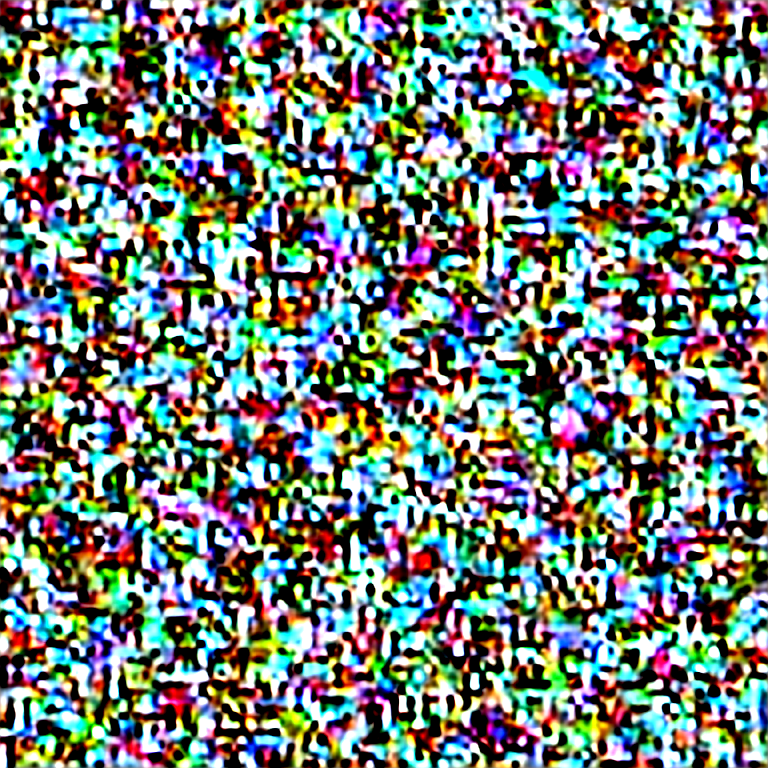

In [15]:
images[0]

In [17]:
import logging
from typing import Sequence
from functools import partial

import torch
import torch._dynamo as td
from torch_tensorrt.dynamo.backend.lowering._decompositions import (
    get_decompositions,
)
from torch_tensorrt.dynamo.backend.lowering._partition import (
    partition,
    get_submod_inputs,
)
from torch_tensorrt.dynamo.backend._settings import CompilationSettings
from torch_tensorrt.dynamo.backend.utils import prepare_inputs, prepare_device
from torch_tensorrt.dynamo.backend.backends import aot_torch_tensorrt_aten_backend
from torch_tensorrt.dynamo.backend._defaults import (
    PRECISION,
    DEBUG,
    MAX_WORKSPACE_SIZE,
    MIN_BLOCK_SIZE,
    PASS_THROUGH_BUILD_FAILURES,
)
from torch._dynamo.backends.common import fake_tensor_unsupported
from torch._functorch.aot_autograd import aot_module_simplified, make_boxed_compiler
from torch_tensorrt.dynamo.backend.lowering._partition import logger as plogger
from torch_tensorrt.dynamo.backend.conversion import convert_module

from nos.compilers.trt.ops import group_norm as gn
# from nos.compilers.trt.backends import nos_tensorrt_backend


from torch._functorch.aot_autograd import aot_module_simplified, make_boxed_compiler

logger = logging.getLogger(__name__)


def _compile_module(
    gm: torch.fx.GraphModule,
    sample_inputs: Sequence[torch.Tensor],
    settings: CompilationSettings = CompilationSettings(),
) -> torch.fx.GraphModule:
    """Compile a traced FX module

    Includes: Partitioning + Conversion Phases

    Args:
        module: FX GraphModule to convert
        inputs: Inputs to the module
        settings: Compilation settings
    Returns:
        Compiled FX GraphModule
    """
    # Partition module into components that can be TRT-accelerated
    print(f"NOS compile:")
    level = plogger.level
    plogger.setLevel(logging.DEBUG)
    partitioned_module = partition(
        gm,
        verbose=settings.debug,
        min_block_size=settings.min_block_size,
        torch_executed_ops=settings.torch_executed_ops,
    )
    plogger.setLevel(level)

    # Iterate over all components that can be accelerated
    # Generate the corresponding TRT Module for those
    for name, _ in partitioned_module.named_children():
        # TOFIX (spillai): Investigate why this is needed here, 
        # but not in torch dynamo.
        if "_run_on_acc" not in name:
            print(f"Skipping partition: {name}")
            continue
        submodule = getattr(partitioned_module, name)

        # Get submodule inputs
        submodule_inputs = get_submod_inputs(
            partitioned_module, submodule, sample_inputs
        )

        # Create TRT Module from submodule
        trt_mod = convert_module(
            submodule,
            submodule_inputs,
            settings=settings,
        )

        # Replace FX Module with TRT Module
        setattr(partitioned_module, name, trt_mod)

    return partitioned_module

@fake_tensor_unsupported
def _pretraced_backend(
    gm: torch.fx.GraphModule,
    sample_inputs: Sequence[torch.Tensor],
    settings: CompilationSettings = CompilationSettings(),
):
    """Helper function to manage translation of traced FX module to TRT engines

    Args:
        module: FX GraphModule to convert
        inputs: Inputs to the module
        settings: Compilation settings
    Returns:
        Compiled FX GraphModule
    """
    try:
        trt_compiled = _compile_module(
            gm,
            sample_inputs,
            settings=settings,
        )
        return trt_compiled
    except:
        logger.error(
            "FX2TRT conversion failed on the subgraph. See trace above. "
            + "Returning GraphModule forward instead.",
            exc_info=True,
        )

        if not settings.pass_through_build_failures:
            return gm.forward
        else:
            raise AssertionError(
                "Halting compilation on build failure since "
                + "pass_through_build_failures was specified as True. "
                + "To return the default Torch implementation and avoid "
                + "halting compilation on engine build failures, "
                + "specify pass_through_build_failures=False."
            )



@fake_tensor_unsupported
def nos_tensorrt_backend(
    gm: torch.fx.GraphModule,
    sample_inputs: Sequence[torch.Tensor],
    settings: CompilationSettings = CompilationSettings(),
):
    custom_backend = partial(
        _pretraced_backend,
        settings=settings,
    )

    print("nos_trt_backend() called with FX graph:")
    gm.graph.print_tabular()

    # print("Acc Tracer")
    # with torch.inference_mode():
    #     gm = acc_tracer.trace(
    #         gm, sample_inputs, 
    #     )

    # Invoke AOTAutograd to translate operators to aten
    return _pretraced_backend(gm, sample_inputs, settings=settings)
    
    # return aot_module_simplified(
    #     gm,
    #     sample_inputs,
    #     fw_compiler=make_boxed_compiler(custom_backend),
    #     decompositions=get_decompositions(),
    # )


def create_backend(
    precision: LowerPrecision = PRECISION,
    debug: bool = DEBUG,
    workspace_size: int = MAX_WORKSPACE_SIZE,
    min_block_size: int = MIN_BLOCK_SIZE,
    torch_executed_ops: Sequence[str] = set(),
    pass_through_build_failures: bool = PASS_THROUGH_BUILD_FAILURES,
    **kwargs,
):
    """Create torch.compile backend given specified arguments

    Args:
        precision: Model Layer precision
        debug: Whether to print out verbose debugging information
        workspace_size: Workspace TRT is allowed to use for the module (0 is default)
        min_block_size: Minimum number of operators per TRT-Engine Block
        torch_executed_ops: Sequence of operations to run in Torch, regardless of converter coverage
        pass_through_build_failures: Whether to fail on TRT engine build errors (True) or not (False)
    Returns:
        Backend for torch.compile
    """
    if debug:
        logger.setLevel(logging.DEBUG)

    settings = CompilationSettings(
        debug=debug,
        precision=precision,
        workspace_size=workspace_size,
        min_block_size=min_block_size,
        torch_executed_ops=torch_executed_ops,
        pass_through_build_failures=pass_through_build_failures,
    )

    return partial(
        nos_tensorrt_backend,
        settings=settings,
    )

In [33]:
import torch
import logging
import collections.abc
import torch_tensorrt
from functools import partial

from typing import Any, Sequence
from torch_tensorrt import EngineCapability, Device
from torch_tensorrt.fx.utils import LowerPrecision


torch._dynamo.config.log_level = logging.INFO
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = True

debug = True
custom_backend = create_backend(
    precision=LowerPrecision.FP32 if dtype == torch.float32 else LowerPrecision.FP16,
    debug=debug,
    workspace_size=MAX_WORKSPACE_SIZE,
    min_block_size=0, # MIN_BLOCK_SIZE,
    torch_executed_ops=[],
)

torch._dynamo.eval_frame.remove_from_cache(model)
with torch.inference_mode():
    trt_model = torch_tensorrt.compile(traced_unet, backend=custom_backend)

with torch.inference_mode():
    trt_model(x)

# Clean up model env
# torch._dynamo.reset()

# with torch.no_grad():
#     torch.cuda.empty_cache()

RuntimeError: 
Python builtin <built-in function setattr> is currently not supported in Torchscript:
  File "/tmp/ipykernel_2760/1910788596.py", line 22
        for arg in args:
            key = self._input_idx2name[idx]
            setattr(self, key, arg)
            ~~~~~~~ <--- HERE
            print(f"setting {key}: {arg.shape}")
            idx += 1


In [ ]:
trt_model = torch_tensorrt.fx.compile(traced_model, 
                                    (),
                                    min_acc_module_size=0,
                                    max_batch_size=2048,
                                    max_workspace_size=33554432,
                                    lower_precision=LowerPrecision.FP32 if dtype == torch.float32 else LowerPrecision.FP16,
                                    verbose_log=True,
                                    timing_cache_prefix='',
                                    save_timing_cache=False,
                                    cuda_graph_batch_size=-1,
                                    is_aten=False,
                                    use_experimental_fx_rt=False,
                                    explicit_batch_dimension=True, 
                                    dynamic_batch=False
)

In [ ]:
pipe.vae = trt_model

In [ ]:
images = pipe(prompt=["fox jumped over dog"], num_inference_steps=200, num_images_per_prompt=1).images

In [ ]:
filename = "norm_trt_engine.pt"
torch.save(trt_model, filename)
trt_model = torch.load(filename)

In [ ]:
with torch.inference_mode():
    result = model(x)
# result

In [ ]:
with torch.inference_mode():
    result = trt_model(x)
# result

In [ ]:
%%timeit -n 10 -r 3
with torch.inference_mode():
    model(x)

In [ ]:
%%timeit -n 10 -r 3
with torch.inference_mode():
    trt_model(x)

In [ ]:
trt_mod(x)

In [ ]:
%%